# Power comparison under different hypotheses

In hypothesis testing, we can test different hypotheses. The most common are:
- Two-sided: the effect is different from zero (commonly noted as H0: beta = 0, H1: beta != 0)
- Less: the effect is less than zero (H0: beta >= 0, H1: beta < 0)
- Greater: the effect is greater than zero (H0: beta <= 0, H1: beta > 0)

In the example below, we show how different hypotheses affect the power of the test. We use the same data as in a previous example.

In [10]:
from datetime import date
import numpy as np
import pandas as pd
from cluster_experiments import PowerAnalysis
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

N = 1000
clusters = [f"Cluster {i}" for i in range(50)]
dates = [f"{date(2022, 1, i):%Y-%m-%d}" for i in range(1, 32)]
df = pd.DataFrame(
    {
        "cluster": np.random.choice(clusters, size=N),
        "target": np.random.normal(0, 1, size=N),
        "date": np.random.choice(dates, size=N),
    }
)



# OLS

Let's start with a simple OLS model, not clustered, to understand the difference in power. We will try 2 different splitter: constant and normal

In [2]:
results = []

In [3]:
splitters = ['constant', 'normal']

for hypothesis in ["two-sided", "less", "greater"]:
        for splitter in splitters:
                config = {
                    "analysis": 'ols',
                    "perturbator": splitter,
                    "splitter": "non_clustered",
                    "n_simulations": 50,
                    "hypothesis": hypothesis,
                    "seed":41
                }
                pw = PowerAnalysis.from_dict(config)

                power_dict = pw.power_line(df, average_effects=[0.0001, 0.01, 0.02, 0.03, 0.5])
                power_df = pd.DataFrame(list(power_dict.items()), columns=['average_effect', 'power'])

                power_df['hypothesis'] = hypothesis
                power_df['splitter'] = splitter

                results.append(power_df)


final_df = pd.concat(results, ignore_index=True)


In [4]:
final_df.sample(10)

,average_effect,power,hypothesis,splitter
0,0.0001,0.04,two-sided,constant
24,0.5000,1.00,greater,constant
5,0.0001,0.04,two-sided,normal
15,0.0001,0.02,less,normal
1,0.0100,0.04,two-sided,constant
25,0.0001,0.02,greater,normal
16,0.0100,0.00,less,normal
7,0.0200,0.06,two-sided,normal
28,0.0300,0.20,greater,normal
17,0.0200,0.00,less,normal


In [5]:
def plot(breakdown:str):
    for iter in final_df[breakdown].unique():
        fig, ax = plt.subplots()
        for category, group in final_df.query(f"{breakdown} == @iter").groupby('hypothesis'):
            ax.plot(group['average_effect'], group['power'], label=category)
        ax.set_xlabel("Average effect")
        ax.set_ylabel("Power")
        ax.set_title(f"Power curve - {breakdown}={iter}")
        ax.legend()
        plt.show()

    

We can clearly see that using the correct side (higher, as the effect is positive) increase the power of the experiment. It's also great to see such a low power in case of hypothesis 'less'. 

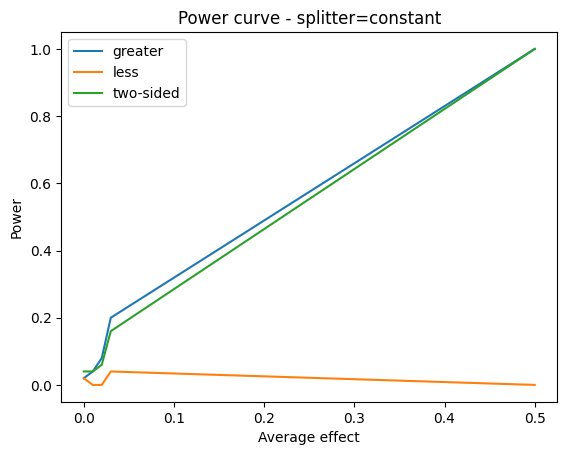

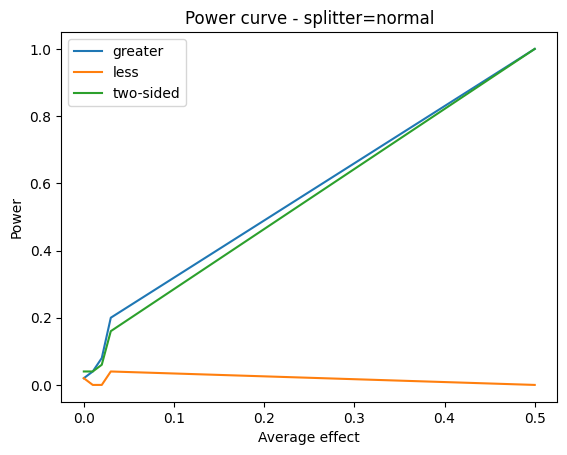

In [6]:
plot(breakdown = 'splitter')

# Clustered methods

Now let's move to clustered methods. To keep the notebook tidy, we will just run the constant perturbator. 

In [7]:
results = []

for hypothesis in ["two-sided", "less", "greater"]:
        for analysis in ["ols_clustered", "gee", 'ttest_clustered']:
                config = {
                    "analysis": analysis,
                    "perturbator": "constant",
                    "splitter": "clustered",
                    "n_simulations": 50,
                    "hypothesis": hypothesis,
                    "cluster_cols": ['cluster', 'date'],
                    "seed":41
                }
                pw = PowerAnalysis.from_dict(config)

                power_dict = pw.power_line(df, average_effects=[0, 0.01, 0.02, 0.03, 0.5])
                power_df = pd.DataFrame(list(power_dict.items()), columns=['average_effect', 'power'])

                power_df['hypothesis'] = hypothesis
                power_df['analysis'] = analysis

                results.append(power_df)


final_df = pd.concat(results, ignore_index=True)



In [8]:
final_df.sample(10)

,average_effect,power,hypothesis,analysis
14,0.50,1.00,two-sided,ttest_clustered
44,0.50,1.00,greater,ttest_clustered
10,0.00,0.08,two-sided,ttest_clustered
15,0.00,0.06,less,ols_clustered
7,0.02,0.00,two-sided,gee
33,0.03,0.12,greater,ols_clustered
8,0.03,0.08,two-sided,gee
30,0.00,0.06,greater,ols_clustered
5,0.00,0.06,two-sided,gee
40,0.00,0.06,greater,ttest_clustered


Here, again, we see an increase in power using the correct one-sided hypothesis compared to two-sided. 

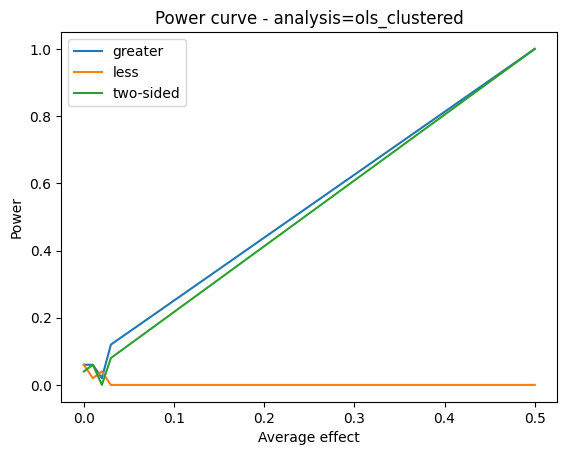

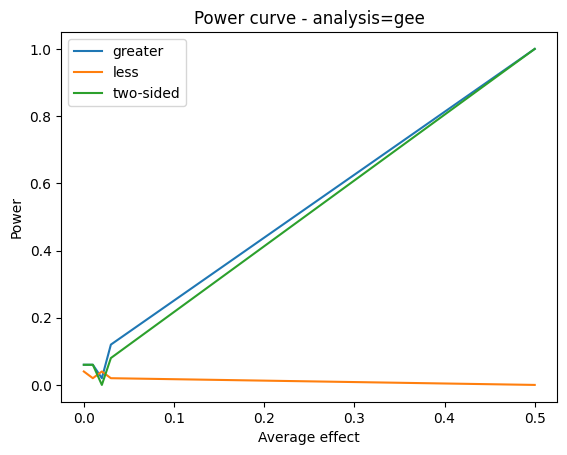

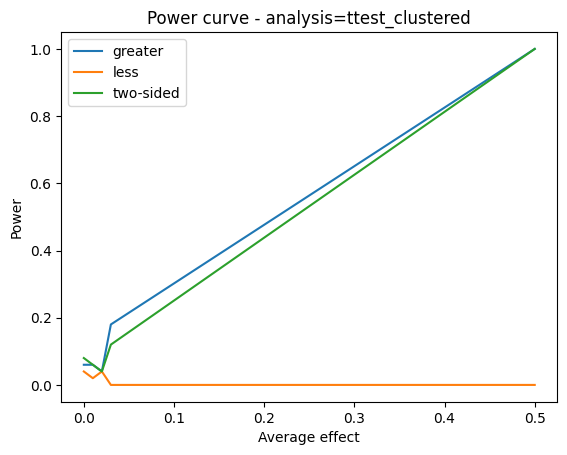

In [9]:
plot(breakdown = 'analysis')